# Variance Gamma Distribution

This notebook demonstrates the **Variance Gamma (VG)** distribution, a normal variance-mean mixture where the mixing distribution is Gamma.

## Mathematical Definition

The Variance Gamma distribution is defined as a normal mixture:

$$X | Y \sim N(\mu + \gamma Y, \Sigma Y)$$

$$Y \sim \text{Gamma}(\alpha, \beta)$$

where:
- $\mu \in \mathbb{R}^d$: location parameter
- $\gamma \in \mathbb{R}^d$: skewness parameter  
- $\Sigma \in \mathbb{R}^{d \times d}$: covariance scale matrix (positive definite)
- $\alpha > 0$: Gamma shape parameter
- $\beta > 0$: Gamma rate parameter

## Key Properties

| Property | Formula |
|----------|--------|
| Mean | $E[X] = \mu + \gamma \frac{\alpha}{\beta}$ |
| Covariance | $\text{Cov}[X] = \frac{\alpha}{\beta} \Sigma + \frac{\alpha}{\beta^2} \gamma \gamma^T$ |

## Distribution Types

- **Joint distribution** $f(x, y)$: Exponential family (tractable)
- **Marginal distribution** $f(x)$: NOT exponential family (requires EM for fitting)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats

from normix.distributions.mixtures import JointVarianceGamma, VarianceGamma
from normix.distributions.univariate import Gamma
from normix.utils import (
    plot_joint_distribution_1d,
    plot_marginal_distribution_2d,
    validate_moments,
    print_moment_validation,
    fit_and_track_convergence,
    plot_em_convergence,
    test_joint_fitting,
    print_fitting_results
)

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Consistent styling
COLORS = {'primary': 'tab:blue', 'secondary': 'tab:red', 'tertiary': 'tab:green'}
np.set_printoptions(precision=4, suppress=True)

## Parameter Sets for Testing

We test with three different parameter configurations to demonstrate the distribution's flexibility.

In [2]:
# Define three parameter sets for comprehensive testing
PARAM_SETS = [
    {
        'name': 'Symmetric (γ=0)',
        'mu': np.array([0.0, 0.0]),
        'gamma': np.array([0.0, 0.0]),
        'sigma': np.array([[1.0, 0.3], [0.3, 1.0]]),
        'shape': 2.0,
        'rate': 1.0
    },
    {
        'name': 'Right-skewed (γ>0)',
        'mu': np.array([0.0, 0.0]),
        'gamma': np.array([0.5, 0.3]),
        'sigma': np.array([[1.0, 0.2], [0.2, 1.5]]),
        'shape': 3.0,
        'rate': 2.0
    },
    {
        'name': 'Left-skewed (γ<0)',
        'mu': np.array([1.0, -0.5]),
        'gamma': np.array([-0.4, 0.2]),
        'sigma': np.array([[2.0, -0.5], [-0.5, 1.0]]),
        'shape': 4.0,
        'rate': 1.5
    }
]

# Display parameter sets
for i, params in enumerate(PARAM_SETS):
    print(f"\nParameter Set {i+1}: {params['name']}")
    print(f"  μ = {params['mu']}")
    print(f"  γ = {params['gamma']}")
    print(f"  α = {params['shape']}, β = {params['rate']}")


Parameter Set 1: Symmetric (γ=0)
  μ = [0. 0.]
  γ = [0. 0.]
  α = 2.0, β = 1.0

Parameter Set 2: Right-skewed (γ>0)
  μ = [0. 0.]
  γ = [0.5 0.3]
  α = 3.0, β = 2.0

Parameter Set 3: Left-skewed (γ<0)
  μ = [ 1.  -0.5]
  γ = [-0.4  0.2]
  α = 4.0, β = 1.5


---
# Part 1: Joint Distribution (1D X)

The joint distribution $f(x, y)$ is an **exponential family** with natural parameters.

In [3]:
def get_1d_params(params):
    """Extract 1D version of parameters."""
    return {
        'mu': np.array([params['mu'][0]]),
        'gamma': np.array([params['gamma'][0]]),
        'sigma': np.array([[params['sigma'][0, 0]]]),
        'shape': params['shape'],
        'rate': params['rate']
    }

## 1.1 Joint Distribution Visualization


Parameter Set 1: Symmetric (γ=0)


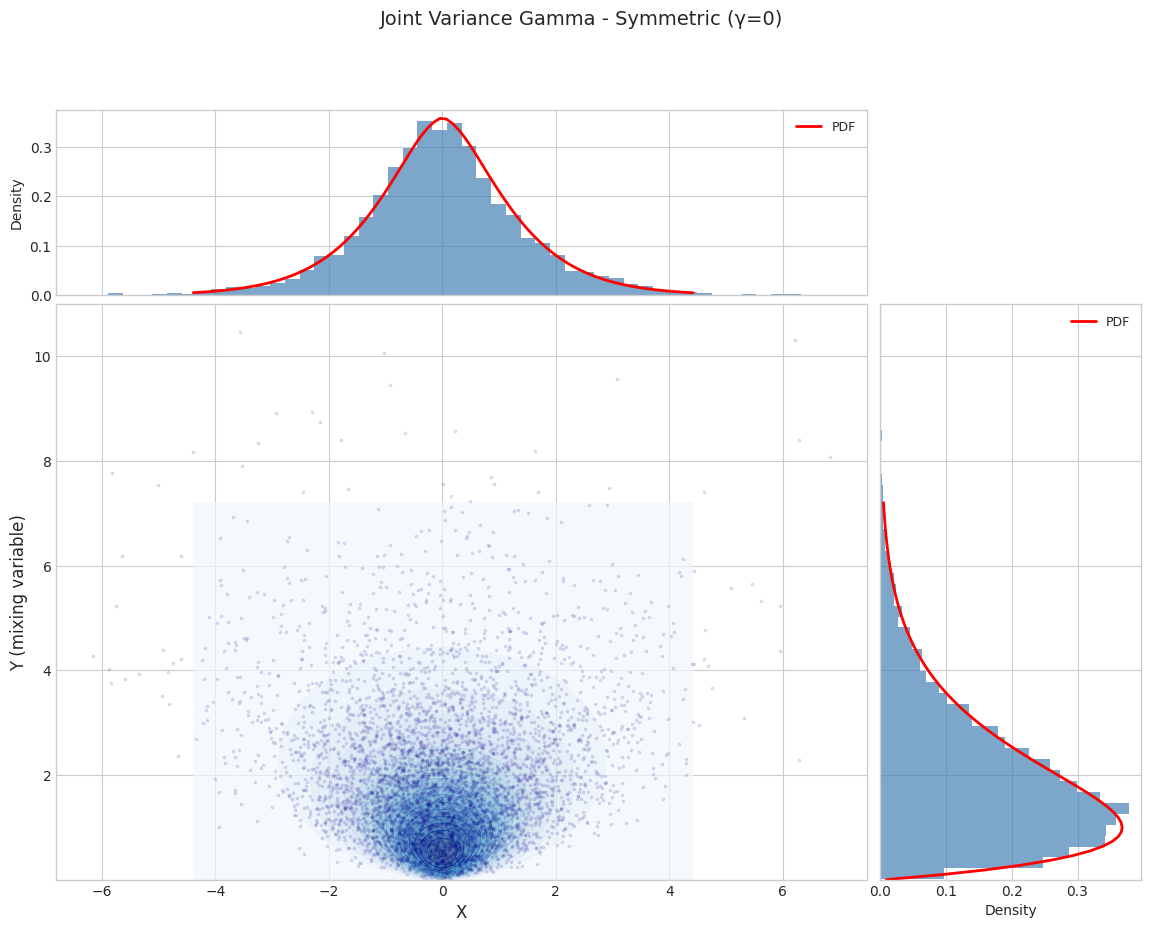


Parameter Set 2: Right-skewed (γ>0)


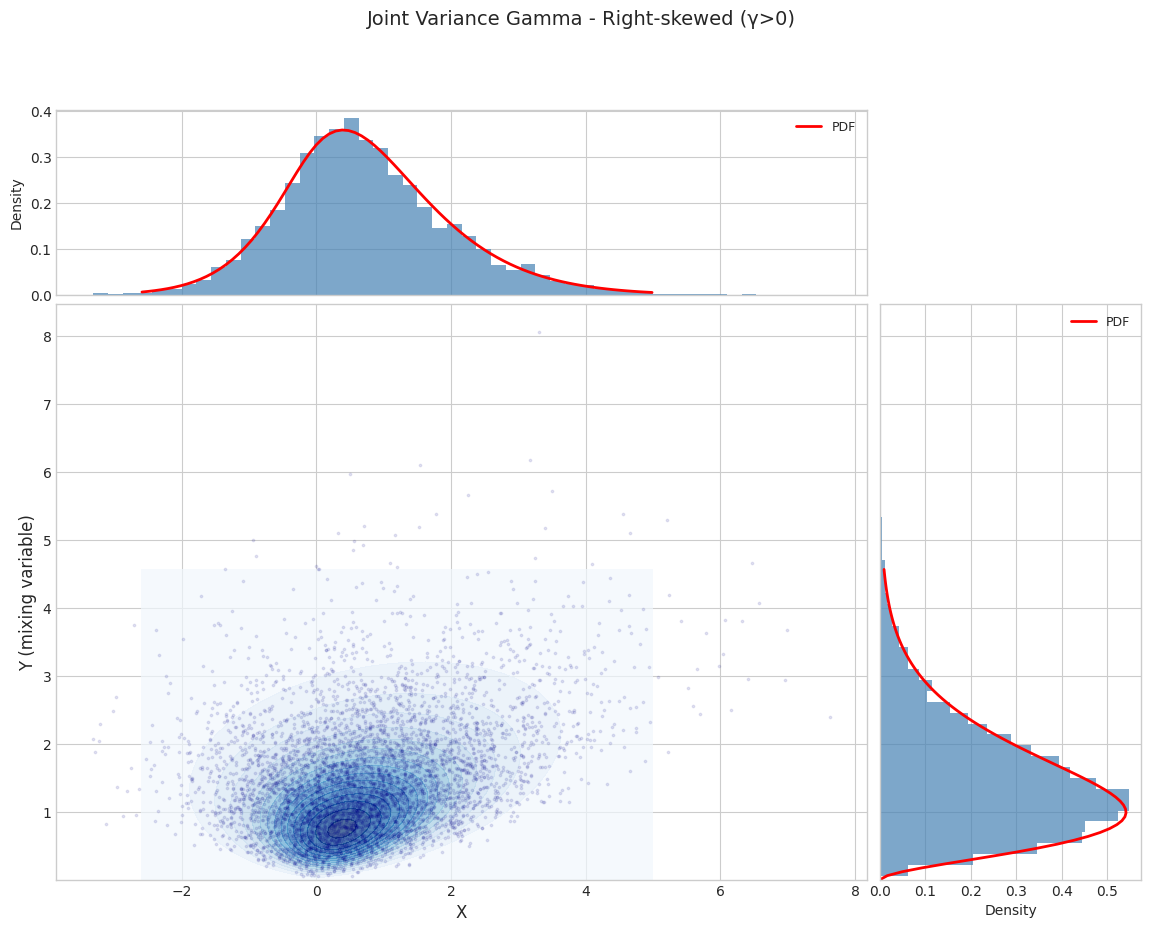


Parameter Set 3: Left-skewed (γ<0)


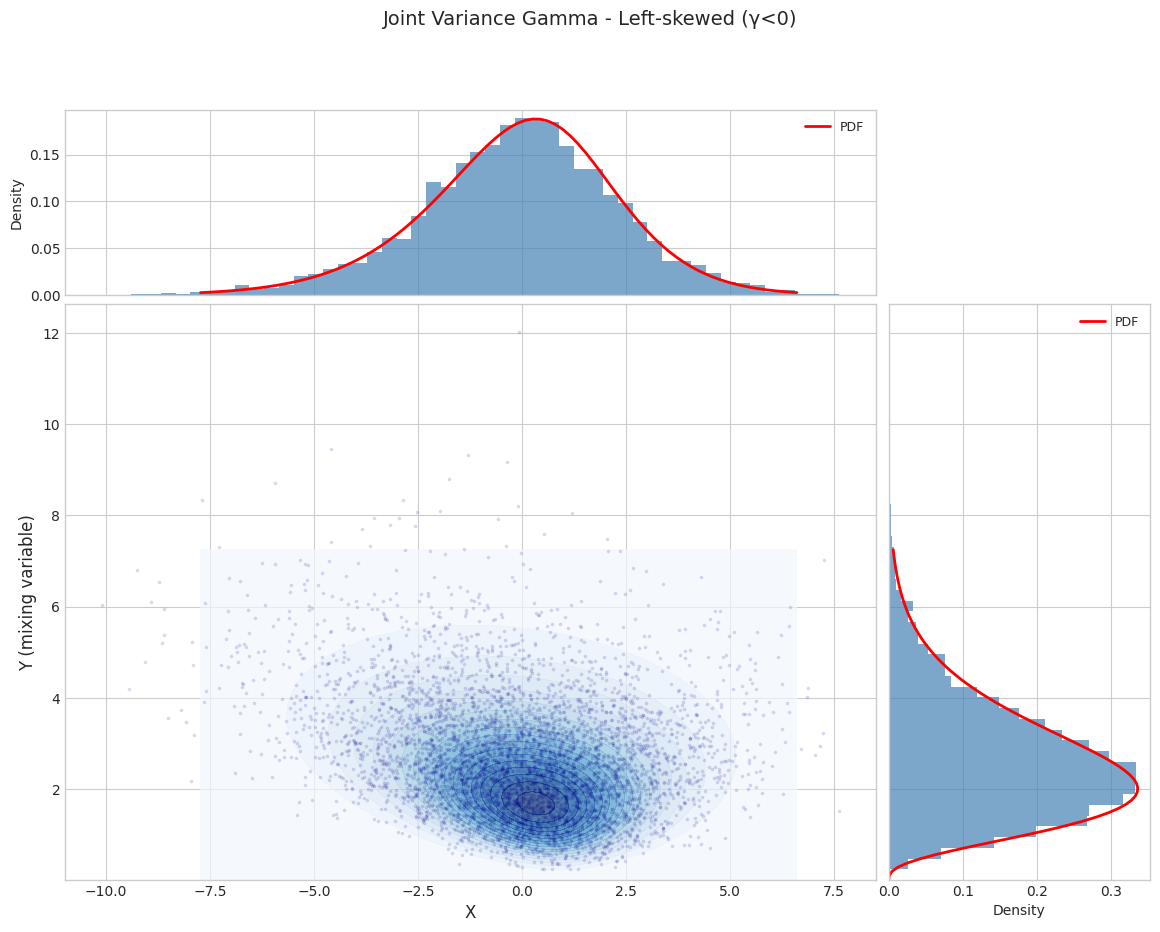

In [4]:
N_SAMPLES = 5000

for i, params in enumerate(PARAM_SETS):
    params_1d = get_1d_params(params)
    joint_dist = JointVarianceGamma.from_classical_params(**params_1d)
    
    print(f"\n{'='*70}")
    print(f"Parameter Set {i+1}: {params['name']}")
    print(f"{'='*70}")
    
    fig = plot_joint_distribution_1d(
        joint_dist, 
        n_samples=N_SAMPLES, 
        random_state=42,
        title=f"Joint Variance Gamma - {params['name']}"
    )
    plt.show()

## 1.2 Moment Validation (Joint)

In [5]:
for i, params in enumerate(PARAM_SETS):
    params_1d = get_1d_params(params)
    joint_dist = JointVarianceGamma.from_classical_params(**params_1d)
    
    results = validate_moments(joint_dist, n_samples=50000, random_state=42, is_joint=True)
    print_moment_validation(results, f"Joint VG - {params['name']}")


Moment Validation: Joint VG - Symmetric (γ=0)
X_mean    : sample =    -0.0026, theory =     0.0000, rel_err = 2.60e+07
Y_mean    : sample =     1.9972, theory =     2.0000, rel_err = 1.42e-03
X_var     : sample =     2.0228, theory =     2.0000, rel_err = 1.14e-02
Y_var     : sample =     2.0111, theory =     2.0000, rel_err = 5.57e-03

Moment Validation: Joint VG - Right-skewed (γ>0)
X_mean    : sample =     0.7493, theory =     0.7500, rel_err = 9.37e-04
Y_mean    : sample =     1.4979, theory =     1.5000, rel_err = 1.37e-03
X_var     : sample =     1.6943, theory =     1.6875, rel_err = 4.05e-03
Y_var     : sample =     0.7532, theory =     0.7500, rel_err = 4.25e-03

Moment Validation: Joint VG - Left-skewed (γ<0)
X_mean    : sample =    -0.0645, theory =    -0.0667, rel_err = 3.29e-02
Y_mean    : sample =     2.6638, theory =     2.6667, rel_err = 1.08e-03
X_var     : sample =     5.6718, theory =     5.6178, rel_err = 9.61e-03
Y_var     : sample =     1.7867, theory =     1.777

## 1.3 Joint Distribution Fitting (Exponential Family MLE)

In [6]:
for i, params in enumerate(PARAM_SETS):
    params_1d = get_1d_params(params)
    
    fitted_dist, fitted_params, param_errors = test_joint_fitting(
        JointVarianceGamma, 
        params_1d, 
        n_samples=N_SAMPLES, 
        random_state=42
    )
    print_fitting_results(params_1d, fitted_params, param_errors, f"Joint VG - {params['name']}")


Fitting Results: Joint VG - Symmetric (γ=0)
Parameter                  True          Fitted    Rel.Error
------------------------------------------------------------
mu                       0.0000         -0.0106     1.06e+08
gamma                    0.0000          0.0042     4.16e+07
sigma                    1.0000          0.9991     8.67e-04
shape                    2.0000          2.0341     1.70e-02
rate                     1.0000          1.0160     1.60e-02

Fitting Results: Joint VG - Right-skewed (γ>0)
Parameter                  True          Fitted    Rel.Error
------------------------------------------------------------
mu                       0.0000          0.0329     3.29e+08
gamma                    0.5000          0.4672     6.55e-02
sigma                    1.0000          0.9984     1.60e-03
shape                    3.0000          3.0388     1.29e-02
rate                     2.0000          2.0219     1.10e-02

Fitting Results: Joint VG - Left-skewed (γ<0)
Parame

---
# Part 2: Marginal Distribution (2D X)

The marginal distribution $f(x) = \int f(x, y) dy$ is **NOT** an exponential family.

Fitting requires the **EM algorithm**.

## 2.1 Marginal Distribution Visualization


Parameter Set 1: Symmetric (γ=0)


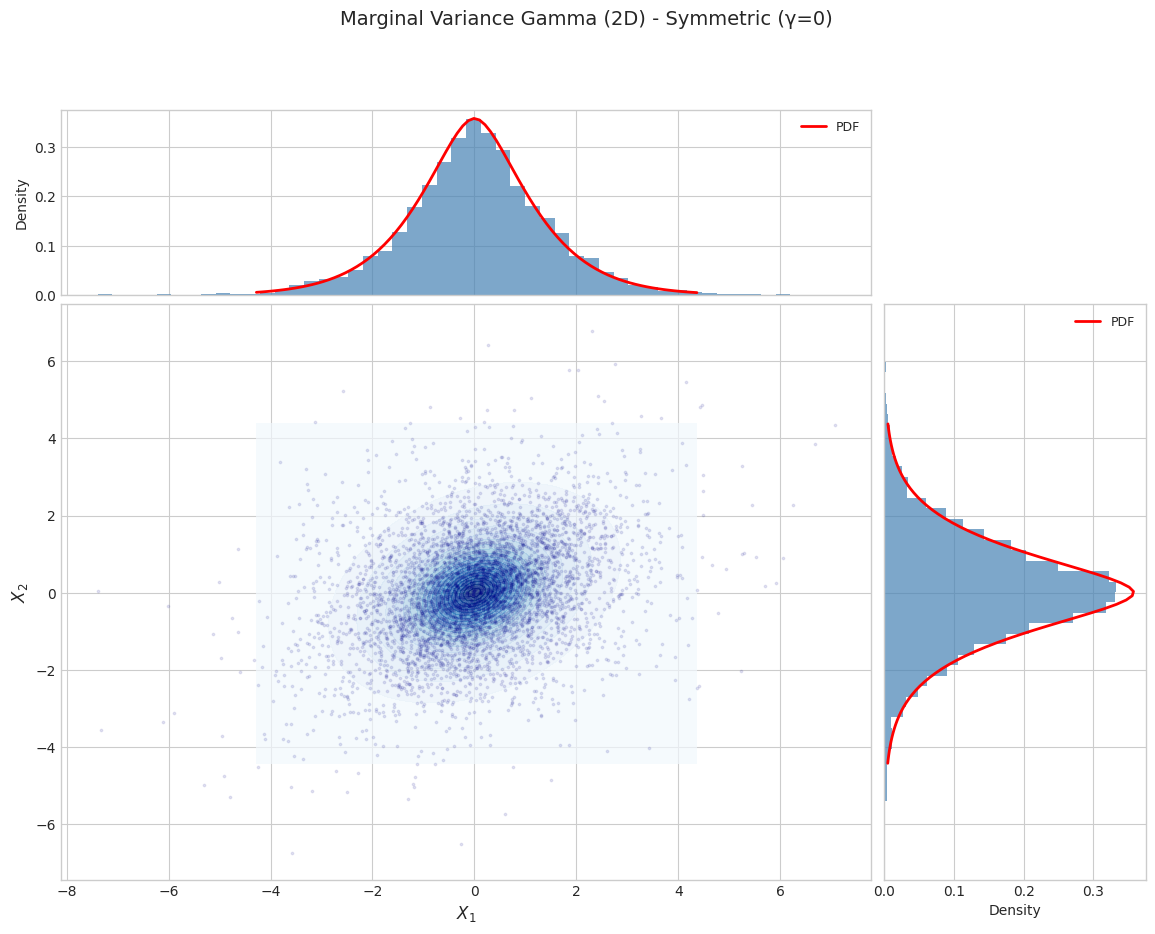


Parameter Set 2: Right-skewed (γ>0)


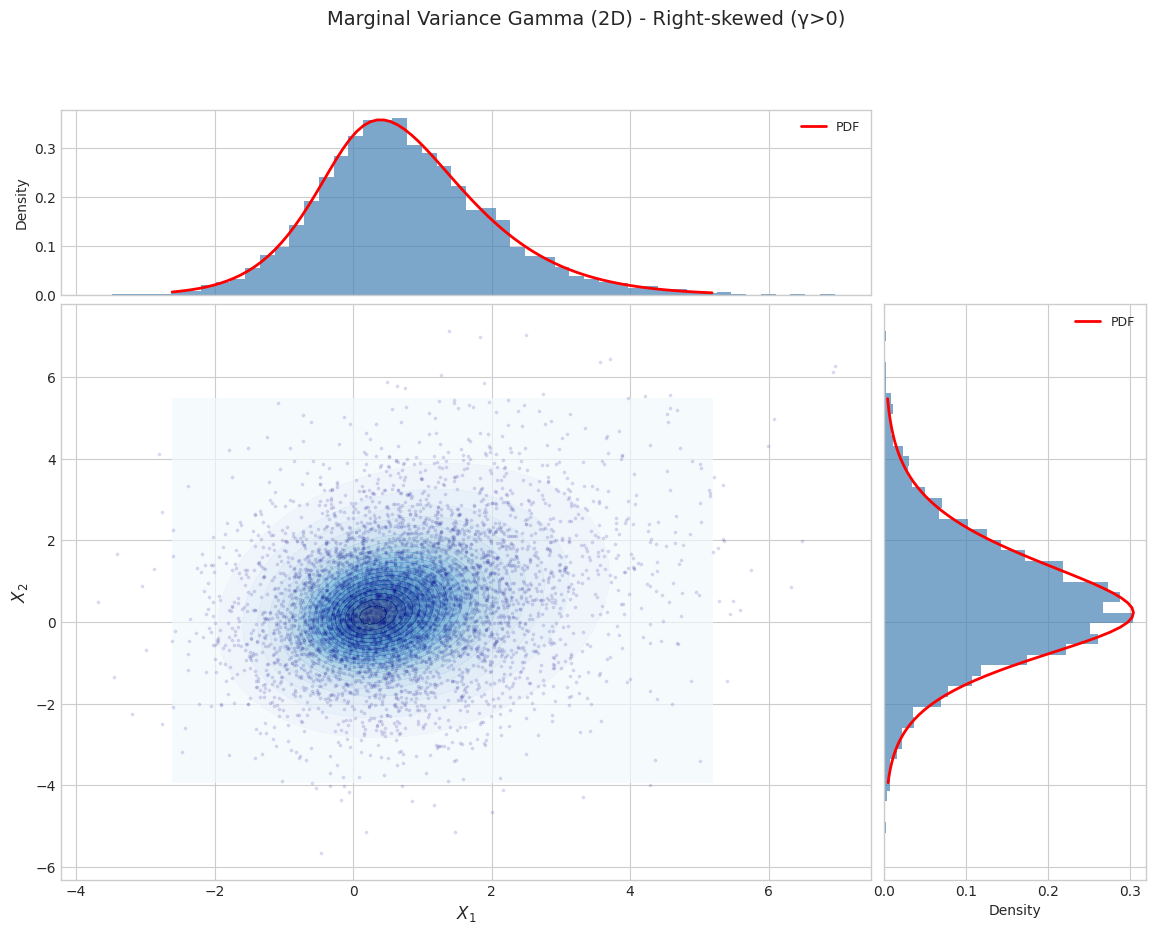


Parameter Set 3: Left-skewed (γ<0)


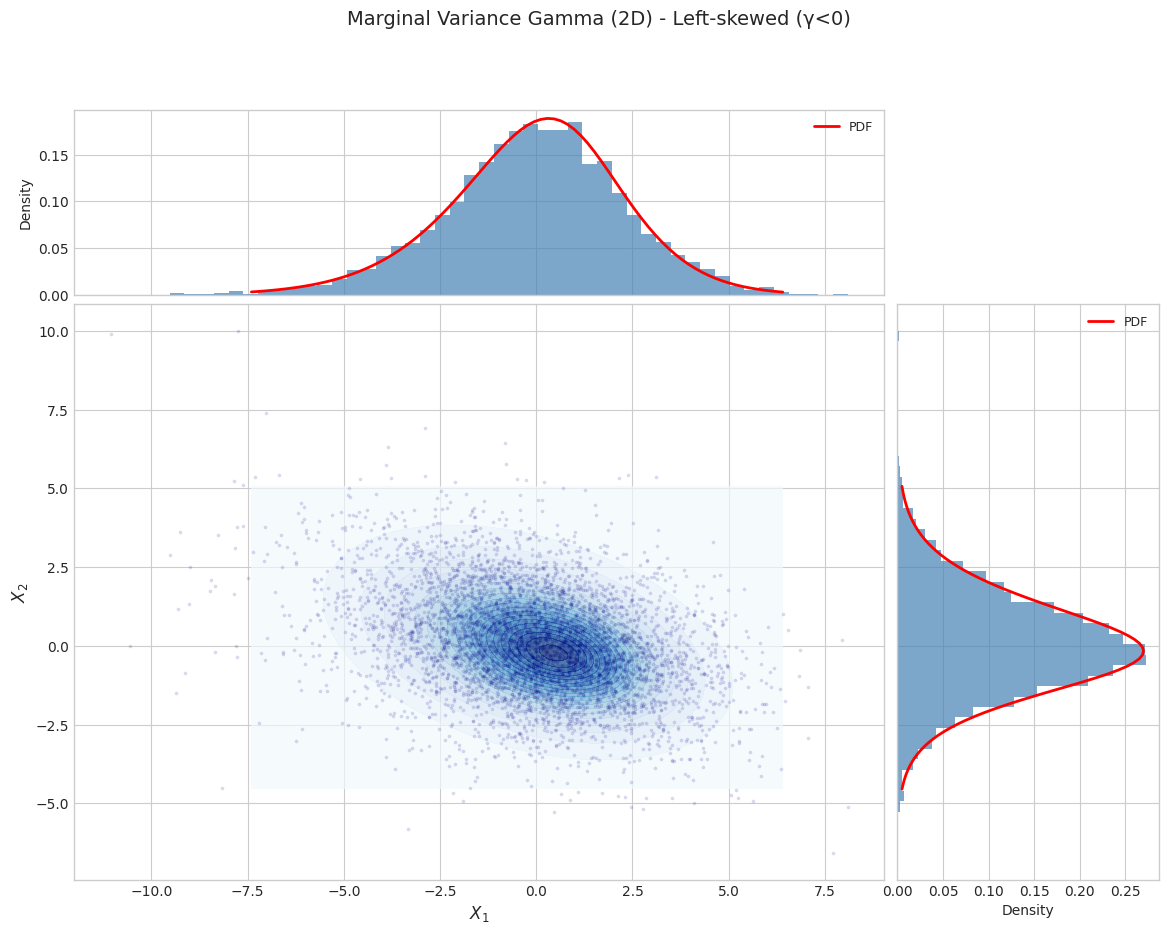

In [7]:
for i, params in enumerate(PARAM_SETS):
    marginal_dist = VarianceGamma.from_classical_params(**params)
    
    print(f"\n{'='*70}")
    print(f"Parameter Set {i+1}: {params['name']}")
    print(f"{'='*70}")
    
    fig = plot_marginal_distribution_2d(
        marginal_dist, 
        n_samples=N_SAMPLES, 
        random_state=42,
        title=f"Marginal Variance Gamma (2D) - {params['name']}"
    )
    plt.show()

## 2.2 Moment Validation (Marginal)

In [8]:
for i, params in enumerate(PARAM_SETS):
    marginal_dist = VarianceGamma.from_classical_params(**params)
    
    results = validate_moments(marginal_dist, n_samples=50000, random_state=42, is_joint=False)
    print_moment_validation(results, f"Marginal VG - {params['name']}")


Moment Validation: Marginal VG - Symmetric (γ=0)
mean      :
  sample = [0.0001 0.0059]
  theory = [0. 0.]
  rel_err = [  650324.98 59205771.04]
variance  :
  sample = [2.0161 1.9783]
  theory = [2. 2.]
  rel_err = [0.01 0.01]

Moment Validation: Marginal VG - Right-skewed (γ>0)
mean      :
  sample = [0.75   0.4503]
  theory = [0.75 0.45]
  rel_err = [0. 0.]
variance  :
  sample = [1.684  2.3255]
  theory = [1.6875 2.3175]
  rel_err = [0. 0.]

Moment Validation: Marginal VG - Left-skewed (γ<0)
mean      :
  sample = [-0.0577  0.0338]
  theory = [-0.0667  0.0333]
  rel_err = [0.13 0.01]
variance  :
  sample = [5.6788 2.7158]
  theory = [5.6178 2.7378]
  rel_err = [0.01 0.01]


## 2.3 EM Algorithm Fitting with Convergence Tracking


Parameter Set 1: Symmetric (γ=0)

Converged: True
Iterations: 20
Initial LL: -3.4339
Final LL:   -3.4336

Parameter Comparison:
  True α = 2.0000, Fitted α = 2.0065
  True β = 1.0000, Fitted β = 1.0028


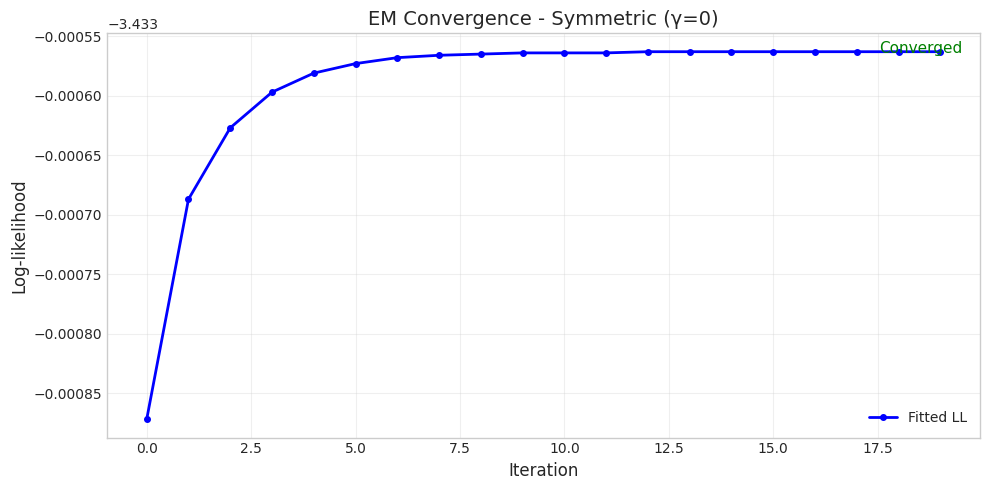


Parameter Set 2: Right-skewed (γ>0)

Converged: True
Iterations: 96
Initial LL: -3.4753
Final LL:   -3.4538

Parameter Comparison:
  True α = 3.0000, Fitted α = 3.2151
  True β = 2.0000, Fitted β = 1.6311


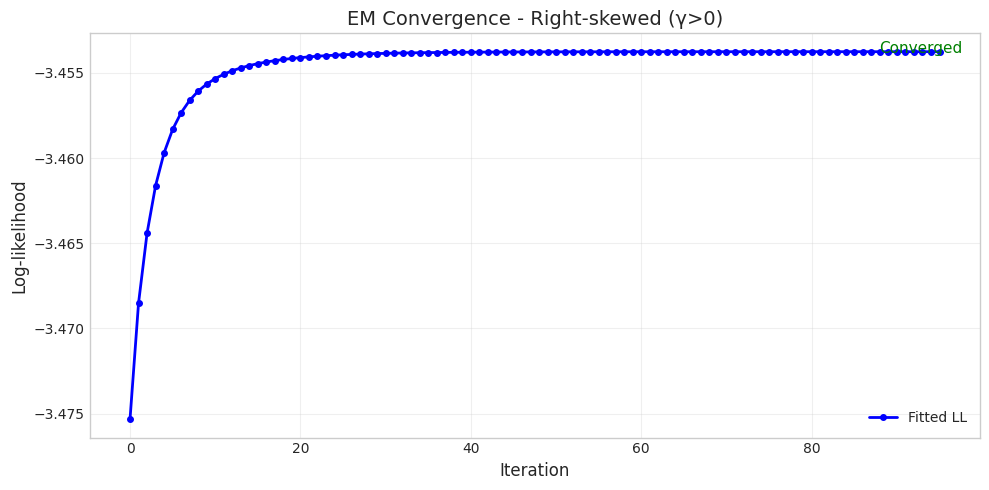


Parameter Set 3: Left-skewed (γ<0)

Converged: True
Iterations: 75
Initial LL: -4.1344
Final LL:   -4.1167

Parameter Comparison:
  True α = 4.0000, Fitted α = 4.2822
  True β = 1.5000, Fitted β = 2.1446


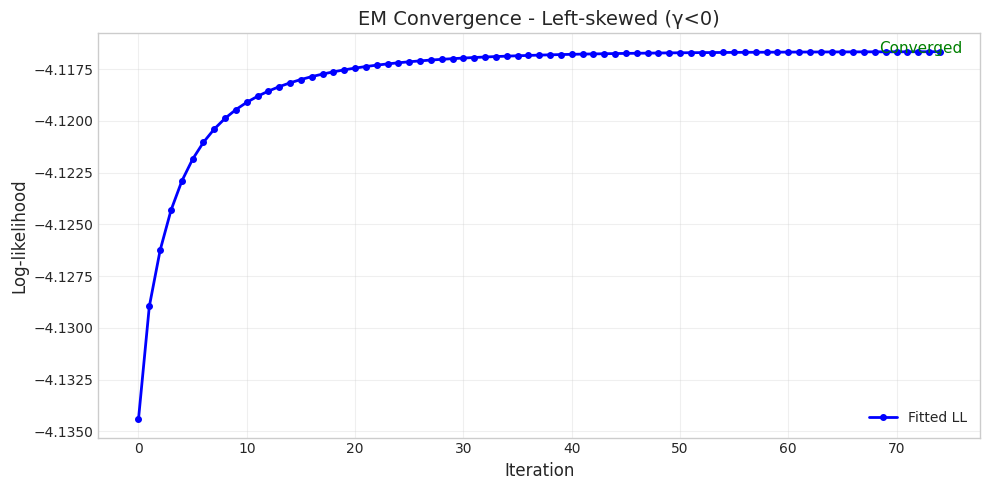

In [9]:
for i, params in enumerate(PARAM_SETS):
    print(f"\n{'='*70}")
    print(f"Parameter Set {i+1}: {params['name']}")
    print(f"{'='*70}")
    
    # Generate data from true distribution
    true_dist = VarianceGamma.from_classical_params(**params)
    X_data = true_dist.rvs(size=N_SAMPLES, random_state=42)
    
    # Fit with EM and track convergence
    fitted_dist, convergence = fit_and_track_convergence(
        VarianceGamma, 
        X_data, 
        max_iter=100, 
        random_state=43
    )
    
    # Print results
    print(f"\nConverged: {convergence.converged}")
    print(f"Iterations: {len(convergence.iterations)}")
    if convergence.log_likelihoods:
        print(f"Initial LL: {convergence.log_likelihoods[0]:.4f}")
        print(f"Final LL:   {convergence.log_likelihoods[-1]:.4f}")
    
    # Compare parameters
    print("\nParameter Comparison:")
    print(f"  True α = {params['shape']:.4f}, Fitted α = {convergence.final_params['shape']:.4f}")
    print(f"  True β = {params['rate']:.4f}, Fitted β = {convergence.final_params['rate']:.4f}")
    
    # Plot convergence
    if convergence.iterations:
        fig = plot_em_convergence(
            convergence,
            title=f"EM Convergence - {params['name']}"
        )
        plt.show()

---
# Part 3: Exponential Family Structure

The joint distribution has the exponential family form:

$$f(x, y | \theta) = h(x, y) \exp(\theta^T t(x, y) - \psi(\theta))$$

In [11]:
# Demonstrate exponential family structure
params_1d = get_1d_params(PARAM_SETS[1])  # Use right-skewed set
joint_dist = JointVarianceGamma.from_classical_params(**params_1d)

print("Exponential Family Structure")
print("="*60)
print(f"\nClassical parameters:")
print(joint_dist.classical_params)

print(f"\nNatural parameters θ:")
print(joint_dist.natural_params)

print(f"\nExpectation parameters η = E[t(X,Y)]:")
print(joint_dist.expectation_params)

Exponential Family Structure

Classical parameters:
{'mu': array([0.]), 'gamma': array([0.5]), 'sigma': array([[1.]]), 'shape': np.float64(3.0), 'rate': np.float64(2.0)}

Natural parameters θ:
[ 1.5    0.    -2.125  0.5    0.    -0.5  ]

Expectation parameters η = E[t(X,Y)]:
[0.2296 1.     1.5    0.75   0.5    1.375 ]


In [13]:
# Verify E[t(X,Y)] matches expectation parameters
X_samples, Y_samples = joint_dist.rvs(size=50000, random_state=42)
t_samples = joint_dist._sufficient_statistics(X_samples, Y_samples)

eta_sample = np.mean(t_samples, axis=0)
eta_theory = joint_dist.expectation_params

print("\nVerification: E[t(X,Y)] from samples vs theory")
print("="*60)
print(f"Sample:     {eta_sample}")
print(f"Theory:     {eta_theory}")
print(f"Max error:  {np.max(np.abs(eta_sample - eta_theory)):.6f}")


Verification: E[t(X,Y)] from samples vs theory
Sample:     [0.2271 1.0032 1.4979 0.7493 0.4958 1.3842]
Theory:     [0.2296 1.     1.5    0.75   0.5    1.375 ]
Max error:  0.009241


---
# Summary

The **Variance Gamma** distribution is a flexible model with:

| Feature | Description |
|---------|-------------|
| Mixing | $Y \sim \text{Gamma}(\alpha, \beta)$ |
| Skewness | Controlled by $\gamma$ |
| Tail behavior | Semi-heavy tails |
| Joint fitting | Exponential family MLE |
| Marginal fitting | EM algorithm |